# Create a Lightcurve Simulator in Gammapy-0.20 (COSI compatible)

## 0 - Setup: import packages of the environment gammapy-0.20

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm

import numpy as np

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table, QTable, hstack
from astropy.io import fits

import logging

In [2]:
from gammapy.data import Observation
from gammapy.datasets import SpectrumDataset, Datasets, FluxPointsDataset
from gammapy.estimators import LightCurveEstimator
from gammapy.irf import (
    EffectiveAreaTable2D,
    Background2D, Background3D,
    EnergyDispersion2D, EDispKernel, EDispKernelMap,
)
from gammapy.makers import SpectrumDatasetMaker
from gammapy.maps import MapAxis, RegionGeom, TimeMapAxis
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ExpCutoffPowerLawSpectralModel,
    SkyModel,
    LightCurveTemplateTemporalModel
)
from gammapy.utils.random import get_random_state

#### Load BAK and RSP files

In [3]:
# GRB 160530 A, COSI

# Input files
input_directory = "/home/gabriele/Documents/cosi/GRB160530A/" # Define Data Directory
file_bak = input_directory+"GRB160530A_bk.pha"                # Define BAK file
file_arf = input_directory+"GRB160530A.arf"                   # Define ARF file for effective area
file_rmf = input_directory+"GRB160530A.rmf"                   # Define RMF file for energy dispersion
file_gbm = "/home/gabriele/Documents/fermiGBM/FermiData/bn160530667/glg_cspec_b0_bn160530667_v00.rsp"

# Energy ranges
INTERP       = 'log'     # Choose how to interpolate the energies # 'lin' or 'log'
slice_energy = True      # Choose if you want to slice the energies and reduce the energy range
custom_range_energy_reco = (105.0,  9995.0) * u.keV # Choose boundaries for the energy range
custom_range_energy_true = (100.0, 10000.0) * u.keV

# Original GBM burst data and light curve best fit
GBM_original_name = '/home/gabriele/Documents/fermiGBM/Output/GRB_160530_A/'
GBM_original_name+= 'b0_200ms_250_40000_keV_fit_LC_table.fits'

# Spectral fit time range and parameters
# Fit: from scat file, GBM Team.
# Detectors used: BGO00 [285,40108] keV, NAI00 & NAI3 [7,908] keV
# Spectral model: Comptonized.
# DRMs: original .rsp files.
spectral_fit_time_range = [5.120, 6.144]
GBM_Ampli = (0.55+0.00) *(u.cm**(-2) * u.s**(-1) * u.keV**(-1)) # Correction factor later
GBM_Index = - (0.627) * u.Unit("")
GBM_Epeak = (259.50) * u.keV
GBM_Erefe = 100.00 * u.keV

# Observation Livetimes parameters: temporal binning of the light curve
time_unit  = u.s
t_start_obs=-5.0 * time_unit # Start time of the observations wrt to trigger time ref_t0
t_stop_obs = 20. * time_unit # Stop time of the observations wrt to trigger time ref_t0
live_t_obs = 0.2 * time_unit # Time duration of each observation
dead_times = 0.0 * time_unit # Rest time between observations

# Number of requested Light Curves
Number_of_LightCurves = 15

# Strings for plot of Light Curves
title_name_transient = "GRB160530A"
title_name_instrument= "COSI"
title_name_prefix    = "COSI_200ms_105_9995_keV_"

# Output directory and table filename
output_directory= "/home/gabriele/Documents/gammapy/LCsim/Output/GRB160530A/"
output_filename = output_directory + title_name_prefix + "lightcurves.fits"

## 1 - Load the Detector Response Matrix

This file is used to define a Reference Time, a Pointing Direction, the True Energy Axis, the Reconstructed Energy Axis, the Detector Response Matrix, the Effective Area.

In [4]:
hdulist_gbm = fits.open(file_gbm)

#### 1.1 - Define the Reference Time of the simulated observations as the Trigger Time

In [5]:
# Define the Trigger Time as the Reference Time of the simulated observations
TIMESYS = hdulist_gbm['PRIMARY'].header['TIMESYS'].lower()

trigger_time_t0 = hdulist_gbm['PRIMARY'].header['MJDREFI']
trigger_time_t0+= hdulist_gbm['PRIMARY'].header['MJDREFF']
trigger_time_t0+= hdulist_gbm['PRIMARY'].header['TRIGTIME'] / 86400.0

trigger_time_t0 = Time(trigger_time_t0,
                       format = 'mjd',
                       scale = TIMESYS
                      )

# Define preferred time format
TimeMapAxis.time_format = "iso" 
trigger_time_t0.format = TimeMapAxis.time_format

# Print
trigger_time_t0

<Time object: scale='tt' format='iso' value=2016-05-30 16:02:20.013>

#### 1.2 - Define the Pointing Direction of the simulated observations and the FoV (Lon, Lat, Offset) axes

We must define a *pointing* direction.
In IACTs this is very close to the target direction, in satellites it is very far in general for GRBs.

In [6]:
# Define the Pointing Direction of the simulated instrument as the Object direction
RA_OBJ  = hdulist_gbm['PRIMARY'].header['RA_OBJ' ]
DEC_OBJ = hdulist_gbm['PRIMARY'].header['DEC_OBJ']
FRAME   = hdulist_gbm['PRIMARY'].header['RADECSYS'].lower()

pointing = SkyCoord(RA_OBJ,
                    DEC_OBJ,
                    unit = "deg",
                    frame = FRAME
                   )

# Print
pointing

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (133.5, 43.5)>

Define Instrument FoV Axes

In [7]:
# Assumption: The FoV Center is (0,0), FoV_Lon and FoV_Lat are symmetric wrt to 0.0

fov_maximum_offset = 5.0 * u.deg
fov_n_bin = 5

# Create Offset axis
axis_offset = MapAxis.from_bounds(0.0,
                                  fov_maximum_offset.value,
                                  unit = fov_maximum_offset.unit,
                                  nbin = fov_n_bin,
                                  name = "offset"
                                 )
# Create Instrument FoV_lon axis
axis_fovlon = MapAxis.from_bounds(-fov_maximum_offset.value/2.0,
                                  +fov_maximum_offset.value/2.0,
                                  unit = fov_maximum_offset.unit,
                                  nbin = fov_n_bin,
                                  name = "fov_lon"
                                 )
# Create Instrument FoV_lat axis
axis_fovlat = MapAxis.from_bounds(-fov_maximum_offset.value/2.0,
                                  +fov_maximum_offset.value/2.0,
                                  unit = fov_maximum_offset.unit,
                                  nbin = fov_n_bin,
                                  name = "fov_lat"
                                 )

# Print
print(axis_offset)
print(axis_fovlon)
print(axis_fovlat)

MapAxis

	name       : offset    
	unit       : 'deg'     
	nbins      : 5         
	node type  : edges     
	edges min  : 0.0e+00 deg
	edges max  : 5.0e+00 deg
	interp     : lin       

MapAxis

	name       : fov_lon   
	unit       : 'deg'     
	nbins      : 5         
	node type  : edges     
	edges min  : -2.5e+00 deg
	edges max  : 2.5e+00 deg
	interp     : lin       

MapAxis

	name       : fov_lat   
	unit       : 'deg'     
	nbins      : 5         
	node type  : edges     
	edges min  : -2.5e+00 deg
	edges max  : 2.5e+00 deg
	interp     : lin       



#### 1.3 - Define the True and Reconstructed Energy Axis

In [8]:
hdulist_rmf = fits.open(file_rmf)

# Print the Information and Primary Header
print(hdulist_rmf.info())
hdulist_rmf['PRIMARY'].header

Filename: /home/gabriele/Documents/cosi/GRB160530A/GRB160530A.rmf
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  MATRIX        1 BinTableHDU     33   502R x 6C   [E, E, I, PI(54), PI(54), PE(161)]   
  2  EBOUNDS       1 BinTableHDU     26   502R x 3C   [I, E, E]   
None


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT  and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H  

Define the Reconstructed Energy Axis.

This is done from the EBOUNDS hdu of the response file.
This name might change.

In [9]:
ebounds = hdulist_rmf['EBOUNDS'].header['EXTNAME']

reco_table = Table.read( hdulist_rmf[ebounds] )

reco_energy_min = reco_table["E_MIN"].quantity
reco_energy_max = reco_table["E_MAX"].quantity

# Define Edges
reco_energy_edges = np.append(reco_energy_min.value, reco_energy_max.value[-1]) * reco_energy_min.unit

# Define Axis
axis_energy_reco = MapAxis.from_edges(reco_energy_edges,
                                      name = "energy",
                                      interp = INTERP
                                     )

# Slice by finding the clostes edges in the energy axis to the requested bounds.
if slice_energy:
    
    range_message = 'Original energy range: [{}, {}] '.format(np.round(axis_energy_reco.bounds[0].value,3),
                                                              np.round(axis_energy_reco.bounds[1].value,3)
                                                             )
    range_message+= str(axis_energy_reco.unit)+f". Energy bins: {axis_energy_reco.nbin}.\n"
    print(range_message)

    dummy_array = axis_energy_reco.edges - custom_range_energy_reco[0]
    i_start_energy_reco = np.argmin(np.abs(dummy_array.value))
    
    dummy_array = axis_energy_reco.edges - custom_range_energy_reco[1]
    i_stop_energy_reco  = np.argmin(np.abs(dummy_array.value))
    
    axis_energy_reco = axis_energy_reco.slice(slice(i_start_energy_reco, i_stop_energy_reco))
    
    range_message = 'Current  energy range: [{}, {}] '.format(np.round(axis_energy_reco.bounds[0].value,3),
                                                              np.round(axis_energy_reco.bounds[1].value,3)
                                                             )
    range_message+= str(axis_energy_reco.unit)+f". Energy bins: {axis_energy_reco.nbin}.\n"
    print(range_message)
    
    
# Print
print(axis_energy_reco)
# reco_table

Original energy range: [1.0, 100000.0] keV. Energy bins: 502.

Current  energy range: [105.516, 9938.83] keV. Energy bins: 299.

MapAxis

	name       : energy    
	unit       : 'keV'     
	nbins      : 299       
	node type  : edges     
	edges min  : 1.1e+02 keV
	edges max  : 9.9e+03 keV
	interp     : log       



Define the True Energy Axis.

This is done from the SPECRESP MATRIX hdu of the response file.
This name might change.

In [10]:
specresp_matrix = hdulist_rmf['MATRIX'].header['EXTNAME']

# Define the True Energy Axis
true_table = Table.read( hdulist_rmf[specresp_matrix] )

true_energy_min = true_table["ENERG_LO"].quantity
true_energy_max = true_table["ENERG_HI"].quantity

# To avoid that min edge is 0
true_energy_min[0] += 1e-2 * (true_energy_max[0] - true_energy_min[0])

# Define Edges
true_energy_edges = np.append(true_energy_min.value, true_energy_max.value[-1]) * true_energy_min.unit

# Define Axis
axis_energy_true = MapAxis.from_edges(true_energy_edges,
                                      name = "energy_true",
                                      interp = INTERP
                                     )

# Slice by finding the clostes edges in the energy axis to the requested bounds.
if slice_energy:
    
    range_message = 'Original energy range: [{}, {}] '.format(np.round(axis_energy_true.bounds[0].value,3),
                                                              np.round(axis_energy_true.bounds[1].value,3)
                                                             )
    range_message+= str(axis_energy_true.unit)+f". Energy bins: {axis_energy_true.nbin}.\n"
    print(range_message)
    
    dummy_array = axis_energy_true.edges - custom_range_energy_true[0]
    i_start_energy_true = np.argmin(np.abs(dummy_array.value))
    
    dummy_array = axis_energy_true.edges - custom_range_energy_true[1]
    i_stop_energy_true  = np.argmin(np.abs(dummy_array.value))
    
    axis_energy_true = axis_energy_true.slice(slice(i_start_energy_true, i_stop_energy_true))
    
    range_message = 'Current  energy range: [{}, {}] '.format(np.round(axis_energy_true.bounds[0].value,3),
                                                              np.round(axis_energy_true.bounds[1].value,3)
                                                             )
    range_message+= str(axis_energy_true.unit)+f". Energy bins: {axis_energy_true.nbin}.\n"
    print(range_message)


# Print
print(axis_energy_true)
# true_table

Original energy range: [1.09, 100000.0] keV. Energy bins: 502.

Current  energy range: [99.291, 9938.83] keV. Energy bins: 303.

MapAxis

	name       : energy_true
	unit       : 'keV'     
	nbins      : 303       
	node type  : edges     
	edges min  : 9.9e+01 keV
	edges max  : 9.9e+03 keV
	interp     : log       



#### 1.5 - Load the Spectral Response Matrix: Effective Area vs True and Reconstructed Energy

In [11]:
Matrix_hdu = hdulist_rmf[specresp_matrix]
Matrix_header = Matrix_hdu.header
Matrix_data = Matrix_hdu.data

Matrix_array = np.zeros([len(Matrix_data), Matrix_header["DETCHANS"]], dtype = np.float64)

for i, l in enumerate(Matrix_data):
    if l.field("N_GRP"):
        m_start = 0
        for k in range(l.field("N_GRP")):
            
            if np.isscalar(l.field("N_CHAN")):
                f_chan = l.field("F_CHAN") - 1
                n_chan = l.field("N_CHAN")
            else:
                f_chan = l.field("F_CHAN")[k] - 1
                n_chan = l.field("N_CHAN")[k]

            Matrix_array[i, f_chan : f_chan+n_chan] = l.field("MATRIX")[m_start : m_start+n_chan]
            m_start += n_chan

# Values are set, now define the unit of measure.
Matrix_unit = true_table['MATRIX'].unit

if slice_energy:
    Matrix_array = Matrix_array[i_start_energy_true:i_stop_energy_true, i_start_energy_reco:i_stop_energy_reco]


## 2 - Source geometry and Energy Dispersion Matrix

#### 2.1 - Define Source Geometry

In [12]:
#### Define the Source Geometry: a region in the sky where the source is placed.
# This represents a single pixel on the sky.

geometry_radius = 1.0 * u.deg
source_geometry_str = FRAME+';circle('+str(RA_OBJ)+', '+str(DEC_OBJ)+', '+str(geometry_radius.value)+')'

# Geometry object: a sky region covered by a pixel, with arbitrary shape and size
geom = RegionGeom.create(source_geometry_str, axes = [axis_energy_reco])

# Print
print(geom)

RegionGeom

	region     : CircleSkyRegion
	axes       : ['lon', 'lat', 'energy']
	shape      : (1, 1, 299)
	ndim       : 3
	frame      : fk5
	center     : 133.5 deg, 43.5 deg



#### 2.2 - Define Energy Dispersion Matrix

P.S. We need to add an exposure map (effective area * observation livetime vs true energy) after we define the livetimes.

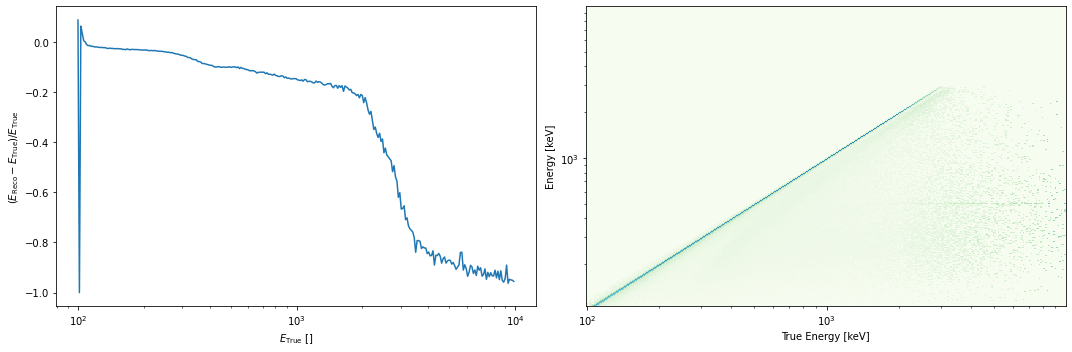

In [13]:
# Build Kernel
edisp = EDispKernel(axes = [axis_energy_true, axis_energy_reco], data = Matrix_array)

# Build EDispKernelMap
edisp = EDispKernelMap.from_edisp_kernel(edisp, geom = geom)

# Peek
edisp.peek()

# Check Normalization
# for r in edisp.edisp_map.data.T[0][0].T:
#     print(len(r), np.sum(r))

#### Define Energy Dispersion from a gaussian

In [ ]:
# # Build Gaussian Kernel
# edisp_gauss = EDispKernel.from_gauss(energy_axis_true = axis_energy_true,
#                                      energy_axis      = axis_energy_reco,
#                                      bias             = 0,
#                                      sigma            = 0.1
#                                     )
# # Build Gaussian EDispKernelMap
# edisp_gauss = EDispKernelMap.from_edisp_kernel(edisp_gauss, geom = geom)

# # Peek
# edisp_gauss.peek()

# # Check normalization
# for r in edisp_gauss.edisp_map.data.T[0][0].T:
#     print(len(r), np.sum(r))

# Effective area from the ARF file

#### 1.6 - Define the Effective Area

Plot the Effective Area vs True Energy

In [14]:
hdulist_arf = fits.open(file_arf)

# Print the Information and Primary Header
print(hdulist_arf.info())
#hdulist_arf['SPECRESP'].header

Filename: /home/gabriele/Documents/cosi/GRB160530A/GRB160530A.arf
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SPECRESP      1 BinTableHDU     25   502R x 3C   [E, E, E]   
None


In [15]:
arf_table= Table.read( hdulist_arf['SPECRESP'] )
arf_table= arf_table[i_start_energy_true: i_stop_energy_true]
arf_table['SPECRESP']=arf_table['SPECRESP'].to(u.cm**2)
#arf_table

EffectiveAreaTable2D
--------------------

  axes  : ['energy_true', 'offset']
  shape : (303, 5)
  ndim  : 2
  unit  : cm2
  dtype : float64



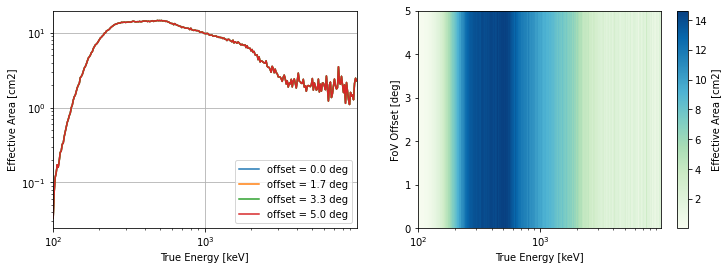

In [16]:
# Compute Effective Area array (as a function of True Energy)
aeff_array = arf_table['SPECRESP'].value

# Compute Effective Area matrix (as a function of True Energy and Offset)
aeff_matrix = np.ndarray( (axis_energy_true.nbin, axis_offset.nbin) )
for i in range(axis_offset.nbin):
    aeff_matrix.transpose()[i] = aeff_array

# Instantiate Effective Area object
aeff = EffectiveAreaTable2D(axes = [axis_energy_true, axis_offset],
                            data = aeff_matrix,
                            unit = arf_table['SPECRESP'].unit
                            # meta = metadata dictionary from header
                           )

# Print
print(aeff)

# Plot
fig, axs = plt.subplots(1,2, figsize=(12,4))

aeff.plot_energy_dependence(ax = axs[0], offset = None)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].grid()

aeff.plot(ax = axs[1], add_cbar = True)
axs[1].set_xscale('log')

plt.show()

## 3 - Load the Background

This is used to define the Backrgound Spectral Model.

Load the Background File

In [17]:
hdulist_bak = fits.open(file_bak)

# Print the Information and Primary Header
print(hdulist_bak.info())
#hdulist_bak['SPECTRUM'].header

Filename: /home/gabriele/Documents/cosi/GRB160530A/GRB160530A_bk.pha
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  SPECTRUM      1 BinTableHDU     36   502R x 2C   [J, J]   
None


In [18]:
# Define the Background Table
bak_table_ebounds = Table.read( hdulist_rmf['EBOUNDS' ] )
bak_table_spectrum= Table.read( hdulist_bak['SPECTRUM'] )

bak_table = Table()
bak_table['CHANNEL'] = bak_table_ebounds['CHANNEL']
bak_table['E_MIN'  ] = bak_table_ebounds['E_MIN'  ]
bak_table['E_MAX'  ] = bak_table_ebounds['E_MAX'  ]
bak_table['RATE'   ] = bak_table_spectrum['COUNTS'].value / ( hdulist_bak['SPECTRUM'].header['EXPOSURE']*u.s)

bak_table['BKG_MOD'] = bak_table['RATE'].quantity / (bak_table['E_MAX'].quantity-bak_table['E_MIN'].quantity)

###############################################################
bak_table['BKG_MOD'] = bak_table['BKG_MOD']/ geom.solid_angle()
###############################################################

# Print
#bak_table

In [19]:
# Define the Background Reconstructed Energy Axis and slice it.
# It may be slightly different from the DRM Reco energy axis.

bak_energy_min = bak_table['E_MIN'].quantity
bak_energy_max = bak_table['E_MAX'].quantity

reco_energy_edges_bkg = np.append(bak_energy_min.value, bak_energy_max.value[-1]) * bak_energy_min.unit
axis_energy_reco_bkg  = MapAxis.from_edges(reco_energy_edges_bkg,
                                           name = "energy",
                                           interp = INTERP
                                          )
if slice_energy:
    
    range_message = 'Original energy range: [{}, {}] '.format(np.round(axis_energy_reco_bkg.bounds[0].value,3),
                                                              np.round(axis_energy_reco_bkg.bounds[1].value,3)
                                                             )
    range_message+= str(axis_energy_reco_bkg.unit)+".\n"
    print(range_message)

    dummy_array = axis_energy_reco_bkg.edges - custom_range_energy_reco[0]
    i_start_energy_reco_bkg = np.argmin(np.abs(dummy_array.value))
    
    dummy_array = axis_energy_reco_bkg.edges - custom_range_energy_reco[1]
    i_stop_energy_reco_bkg  = np.argmin(np.abs(dummy_array.value))
    
    axis_energy_reco_bkg = axis_energy_reco_bkg.slice(slice(i_start_energy_reco_bkg, i_stop_energy_reco_bkg))
    
    range_message = 'Current  energy range: [{}, {}] '.format(np.round(axis_energy_reco_bkg.bounds[0].value,3),
                                                              np.round(axis_energy_reco_bkg.bounds[1].value,3)
                                                             )
    range_message+= str(axis_energy_reco_bkg.unit)+".\n"
    print(range_message)
    
    bak_table = bak_table[i_start_energy_reco_bkg: i_stop_energy_reco_bkg]
    
# Print
print(axis_energy_reco_bkg)
# bak_table

Original energy range: [1.0, 100000.0] keV.

Current  energy range: [105.516, 9938.83] keV.

MapAxis

	name       : energy    
	unit       : 'keV'     
	nbins      : 299       
	node type  : edges     
	edges min  : 1.1e+02 keV
	edges max  : 9.9e+03 keV
	interp     : log       



Background3D
------------

  axes  : ['energy', 'fov_lon', 'fov_lat']
  shape : (299, 5, 5)
  ndim  : 3
  unit  : 1 / (keV s sr)
  dtype : float64



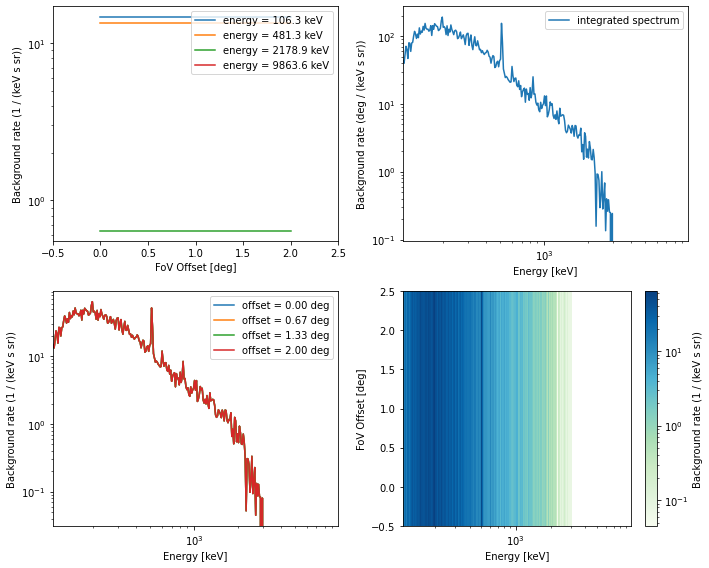

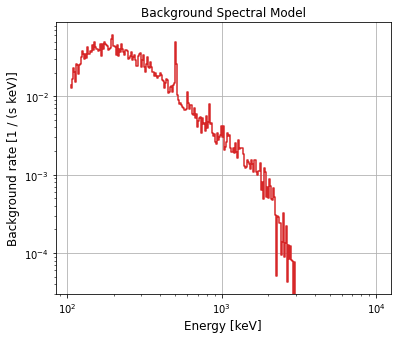

In [24]:
# Prepare Background Matrix (as a function of energy, lon and lat) as ndarray
data_bkg = np.ndarray( (axis_energy_reco_bkg.nbin, axis_fovlon.nbin, axis_fovlat.nbin) )

for i in range(axis_fovlat.nbin):
    for j in range(axis_fovlon.nbin):
        data_bkg.transpose()[i][j] = bak_table['BKG_MOD'].value

# Instantiate Background object # I should add meta=metadata dictionary from header    
bkg = Background3D(axes = [axis_energy_reco_bkg, axis_fovlon, axis_fovlat],
                   data = data_bkg,
                   unit = bak_table['BKG_MOD'].unit,
                   #is_pointlike = False,
                   #fov_alignment = FoVAlignment.RADEC,
                   #meta = None,
                   #interp_kwargs = None
                   )

# Print
print(bkg)

# Plot
bkg.peek()
plt.show()

# Plot as I want
f, a = plt.subplots(1, figsize=(6,5))
a.step(axis_energy_reco_bkg.center.value,
       bkg.data.T[0][0]*geom.solid_angle(),
       color = 'C3'
      )
a.set_xscale('log')
a.set_yscale('log')
a.set_xlabel('Energy [keV]', fontsize = 'large')
a.set_ylabel('Background rate [1 / (s keV)]', fontsize = 'large')
a.set_title('Background Spectral Model', fontsize = 'large')
a.grid()
plt.show()

#### Now create the IRFs dictionary

In [25]:
IRFs = {'aeff' : aeff,
        'bkg'  : bkg
       }

## 4 - Define Temporal and Spectral Model for the simulated source

In [26]:
# Temporal model

GBM_original = QTable.read(GBM_original_name, format = 'fits')

Temporal_Model_Table_Metadata = {'MJDREFI' : int(np.modf(trigger_time_t0.mjd)[1]),
                                 'MJDREFF' :     np.modf(trigger_time_t0.mjd)[0],
                                 'TIMEUNIT': GBM_original['time'].unit.to_string(),
                                 'TIMESYS' : trigger_time_t0.scale
                                }

Temporal_Model_Table = Table(meta = Temporal_Model_Table_Metadata)
Temporal_Model_Table['TIME'] = GBM_original['time']
Temporal_Model_Table['NORM'] = GBM_original['norm']

temporal_model = LightCurveTemplateTemporalModel(Temporal_Model_Table)

# Print
print(temporal_model)

LightCurveTemplateTemporalModel model summary:
Start time: 57538.66713093178 MJD
End time: 57538.66944343178 MJD
Norm min: 1.3976326848216499e-36
Norm max: 1.0



In [27]:
# Evaluate Temporal model at maximum, should return 1
# print(temporal_model.evaluate(trigger_time_t0.mjd+0.075/86400.0))

# Evaluate correction factor
spectral_fit_time_range = [trigger_time_t0.mjd + spectral_fit_time_range[0]/86400.0,
                           trigger_time_t0.mjd + spectral_fit_time_range[1]/86400.0
                          ]
spectral_fit_time_range = Time(spectral_fit_time_range, format = 'mjd')

correction_factor = temporal_model.integral(spectral_fit_time_range[0], spectral_fit_time_range[1])
print(correction_factor)

0.8775418460624792


In [28]:
# Spectral model
spectral_model = ExpCutoffPowerLawSpectralModel(amplitude = GBM_Ampli / correction_factor,
                                                index     = - GBM_Index,
                                                lambda_   = (2.0 + GBM_Index ) / GBM_Epeak,
                                                reference = GBM_Erefe
                                               )
# Print
print(spectral_model)

ExpCutoffPowerLawSpectralModel

  type      name     value         unit        error   min max frozen is_norm link
-------- --------- ---------- -------------- --------- --- --- ------ ------- ----
spectral     index 6.2700e-01                0.000e+00 nan nan  False   False     
spectral amplitude 6.2675e-01 cm-2 keV-1 s-1 0.000e+00 nan nan  False    True     
spectral reference 1.0000e+02            keV 0.000e+00 nan nan   True   False     
spectral   lambda_ 5.2909e-03          keV-1 0.000e+00 nan nan  False   False     
spectral     alpha 1.0000e+00                0.000e+00 nan nan   True   False     


In [29]:
# Complete Source Model = Temporal & Spectral
model_simu = SkyModel(spectral_model = spectral_model,
                      temporal_model = temporal_model,
                      name           = "Compt-TwoPulse"
                     )

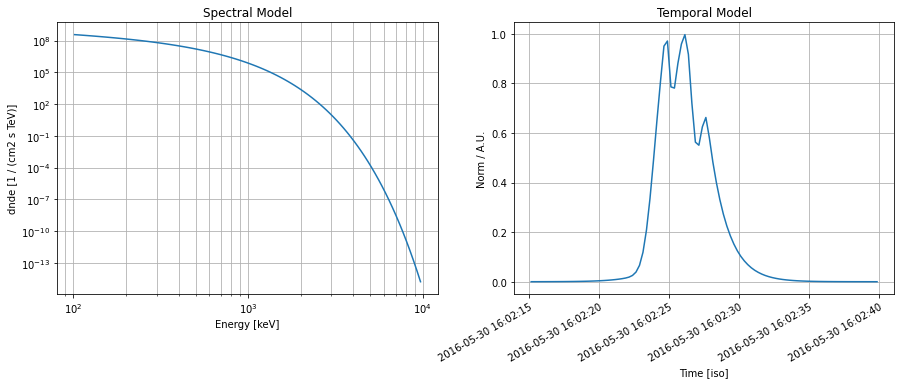

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,int64,float64,float64,bool,bool,str1
spectral,index,6.2700e-01,,0.000e+00,nan,nan,False,False,
spectral,amplitude,6.2675e-01,cm-2 keV-1 s-1,0.000e+00,nan,nan,False,True,
spectral,reference,1.0000e+02,keV,0.000e+00,nan,nan,True,False,
spectral,lambda_,5.2909e-03,keV-1,0.000e+00,nan,nan,False,False,
spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,False,


In [30]:
# Print
fig, axs = plt.subplots(1,2, figsize = (15,5) )

energy_bounds = [axis_energy_true.edges[0], axis_energy_true.edges[-1]]
time_range    = [trigger_time_t0 + t_start_obs, trigger_time_t0 + t_stop_obs ]

spectral_model.plot(energy_bounds, ax = axs[0], sed_type = 'dnde')
temporal_model.plot(time_range, ax = axs[1])

axs[0].set_title('Spectral Model', fontsize = 'large')
axs[1].set_title('Temporal Model', fontsize = 'large')
axs[0].grid(which="both")
axs[1].grid(which="both")

plt.show()

model_simu.parameters.to_table()

## 5 - Define observation number, time parameters and Energy Dispersion

In [31]:
# Estimate Number of observations
n_obs = (t_stop_obs-t_start_obs)/live_t_obs
n_obs = int(np.floor(n_obs.value))

# Define starting time of each observation linearly spaced during the night
starting_times = np.linspace(t_start_obs.value,
                             t_stop_obs.value,
                             num = n_obs
                            )
starting_times = starting_times.tolist() * time_unit

# Define the duration of each observation as the difference between two following starting times
# minus the rest time between them.
livetimes = starting_times[1:] - starting_times[:-1] - dead_times

# Remove last edge to have the same array dimesion for starting times and livetimes.
starting_times = starting_times[:-1]

# Turn them from astropy.units.quantity.Quantity to astropy.time.core.Time with t_ref
starting_times = Time(trigger_time_t0 + starting_times)

# Adjust n_obs
n_obs = starting_times.size

print(n_obs)

124


#### Slice original GBM Data in the time range of our simulations

In [32]:
# Let's find the closed GBM time points 
GBM_i_start= np.argmin(np.abs(GBM_original['time'].value - t_start_obs.value))
GBM_i_stop = np.argmin(np.abs(GBM_original['time'].value - t_stop_obs.value ))

GBM_original_cut = GBM_original[GBM_i_start:GBM_i_stop]

# GBM Data for plot

# Time
GBM_time_val = GBM_original_cut['time'  ].value
GBM_time_wid = GBM_original_cut['time_width'].value

# Count rates
GBM_cnt_rate = GBM_original_cut['cnt_rt'    ].value
GBM_cnt_erro = GBM_original_cut['cnt_rt_err'].value

# Background rates
GBM_bkg_rate = GBM_original_cut['bkg_rt'    ].value
GBM_bkg_erro = GBM_original_cut['bkg_rt_err'].value

# Excess rates
GBM_exc_rate = GBM_cnt_rate - GBM_bkg_rate
GBM_exc_erro = GBM_cnt_erro + GBM_bkg_erro

# Model: best fit excess rates
GBM_exc_pred = GBM_original_cut['best_model'].value

#### Complete IRFs
Now that the livetimes have been computed, complete the IRFs by adding an exposure map to the Edisp.
It is not necessay for the code, since the SpectrumDatasets compute their own exposure, but I want to properly set the EDispKernelMap object by filling its own exposure.

In [33]:
# Set correct Units for exposure map
edisp.exposure_map = edisp.exposure_map.to_unit(aeff.unit * time_unit)

# Initialize the Exposure with effective area values * livetimes. Assume all lifetimes are equal
edisp.exposure_map.data *= 0.0
edisp.exposure_map.data += np.reshape( aeff.data.T[0], edisp.exposure_map.data.T.shape ).T
edisp.exposure_map.data *= livetimes[0].value

########################################## GAUSSIAN
# # Set correct Units for exposure map
# edisp_gauss.exposure_map = edisp_gauss.exposure_map.to_unit(aeff.unit * time_unit)

# # Initialize the Exposure with effective area values * livetimes. Assume all lifetimes are equal
# edisp_gauss.exposure_map.data += np.reshape(aeff.data.T[0], (1,1,1,80)).T
# edisp_gauss.exposure_map.data *= livetimes[0].value

# 6 - Simulations

In [34]:
%%time

# Create a List of Datasets, each will be a Light curve
List_of_Datasets = []
# Fill it with empty Datasets
for i_LC in range(Number_of_LightCurves):
    List_of_Datasets.append(Datasets())
    
    
# Create an empty SpectrumDataset object to host geometry and energy info.
empty = SpectrumDataset.create(geom = geom,
                               energy_axis_true = axis_energy_true,
                               name = "empty",
                               edisp = edisp
                              )

# Create Maker object.
# containment_correction must be set True if I have a PSF, to adapt the
# exposure map and account for PSF broadening and the PSF containment.
maker = SpectrumDatasetMaker(selection = ["exposure",
                                          "background"
                                         ],
                             containment_correction = False
                            )

# This mock light curve will store info on the predicted background and excess rates.
# It won't contain any simulation.
datasets_generic = Datasets()

for idx in range(n_obs):
    print(f'Creating Dataset {idx+1}/{n_obs}...             \r', end = '')
    
    # Set the current observation. Observations differ only in their starting time.
    obs = Observation.create(pointing      = pointing,
                             livetime      = livetimes[idx],
                             tstart        = starting_times[idx],
                             irfs          = IRFs,
                             reference_time= trigger_time_t0,
                             obs_id        = idx
                            )
    
    # Set name according to observation number. Set geometry and energy information.
    dataset_generic = empty.copy(name = f"dataset-{idx}")
    
    # Run: creates the SpectrumDataset. It also sets the Background counts.
    dataset_generic = maker.run(dataset_generic, obs)
    
    # Set the Energy Disperison    
    dataset_generic.edisp = edisp
    
    # Set the source model and compute the predicted excess counts from it.
    dataset_generic.models = model_simu
    
    # For this observation simulate background and counts for each different light curve
    for i_LC in range(Number_of_LightCurves):
               
        dataset = dataset_generic.copy(name = f"LC-{i_LC}"+f"--Dataset-{idx}")
        
        # Set models, that CANNOT BE COPIED
        dataset.models = model_simu
        
        # Introduce Background Fluctuations.
        random_state = get_random_state('random-seed')
        data = np.nan_to_num(dataset.npred_background().data,
                             copy = True, nan = 0.0, posinf = 0.0, neginf = 0.0)
        data = random_state.poisson(data)
        dataset.npred_background().data = data
        dataset.background = dataset.npred_background()
        
        # Simulate counts from Poisson(avg=Predicted Backgrounds+Predicted count excess)
        dataset.fake()
        
        # Add this dataset to the right collection.
        datasets = List_of_Datasets[i_LC]
        datasets.append(dataset)
    
    
    datasets_generic.append(dataset_generic)
    
        
    # Repeat for a new observation.
    
# Loop ended.
print('\nDone.')

Creating Dataset 124/124...             
Done.
CPU times: user 1min, sys: 2.01 s, total: 1min 2s
Wall time: 1min 3s


# 7 - Plot and explore results

The model and background information can be seen in the *generic* datasets, where counts have not been faked.

In [35]:
quicklook_table_generic = datasets_generic.info_table()

print('Columns available:\n', quicklook_table_generic.keys())

show_columns = ['name',
                'background',
                'npred_signal',
                'npred',
                'counts',              
                'livetime',
                'counts_rate',
                'background_rate',
                'excess_rate'
               ]
quicklook_table_generic[show_columns][54:59]

Columns available:
 ['name', 'counts', 'excess', 'sqrt_ts', 'background', 'npred', 'npred_background', 'npred_signal', 'exposure_min', 'exposure_max', 'livetime', 'ontime', 'counts_rate', 'background_rate', 'excess_rate', 'n_bins', 'n_fit_bins', 'stat_type', 'stat_sum']


name,background,npred_signal,npred,counts,livetime,counts_rate,background_rate,excess_rate
,,,,,s,1 / s,1 / s,1 / s
str11,float64,float64,float64,int64,float64,float64,float64,float64
dataset-54,3.1791066936593624,58.46031741001237,61.63942410367175,0,0.20161290322588954,0.0,15.768369200543939,-15.768369200543939
dataset-55,3.1791066936593624,58.801400815309236,61.9805075089686,0,0.20161290322588954,0.0,15.768369200543939,-15.768369200543939
dataset-56,3.1791066936593624,53.968102219378885,57.147208913038234,0,0.20161290322588954,0.0,15.768369200543939,-15.768369200543939
dataset-57,3.1791066936593624,44.568758254384726,47.74786494804408,0,0.20161290322588954,0.0,15.768369200543939,-15.768369200543939
dataset-58,3.1791066936593624,36.05422646825899,39.23333316191835,0,0.20161290322588954,0.0,15.768369200543939,-15.768369200543939


Quick look to a Light curve

In [36]:
quicklook_table = List_of_Datasets[0].info_table()

print('Columns available:\n',quicklook_table.keys())

show_columns = ['name',
                'background',
                'npred_signal',
                'npred',
                'counts',              
                'livetime',
                'counts_rate',
                'background_rate',
                'excess_rate'
               ]
quicklook_table[show_columns][54:59]

Columns available:
 ['name', 'counts', 'excess', 'sqrt_ts', 'background', 'npred', 'npred_background', 'npred_signal', 'exposure_min', 'exposure_max', 'livetime', 'ontime', 'counts_rate', 'background_rate', 'excess_rate', 'n_bins', 'n_fit_bins', 'stat_type', 'stat_sum']


name,background,npred_signal,npred,counts,livetime,counts_rate,background_rate,excess_rate
,,,,,s,1 / s,1 / s,1 / s
str17,float64,float64,float64,int64,float64,float64,float64,float64
LC-0--Dataset-54,1.0,58.46031741001237,59.46031741001237,48,0.20161290322588954,238.07999999990187,4.959999999997956,233.11999999990394
LC-0--Dataset-55,6.0,58.801400815309236,64.80140081530924,62,0.20161290322588954,307.5199999998733,29.759999999987734,277.7599999998855
LC-0--Dataset-56,1.0,53.968102219378885,54.968102219378885,59,0.20161290322588954,292.6399999998794,4.959999999997956,287.67999999988143
LC-0--Dataset-57,4.0,44.568758254384726,48.568758254384726,45,0.20161290322588954,223.19999999990802,19.839999999991825,203.3599999999162
LC-0--Dataset-58,4.0,36.05422646825899,40.05422646825899,36,0.20161290322588954,178.55999999992642,19.839999999991825,158.7199999999346


Average quantities of the Light Curve

In [37]:
n_rows = Number_of_LightCurves
n_cols = n_obs
    
SIM_matrix_cnt_rate = np.empty( (n_rows, n_cols) )
SIM_matrix_bkg_rate = np.empty( (n_rows, n_cols) )

print('Extracting rates from table...')
for i in range(n_rows):
    table_i = List_of_Datasets[i].info_table()
    SIM_matrix_cnt_rate[i] = table_i['counts_rate'    ].value
    SIM_matrix_bkg_rate[i] = table_i['background_rate'].value

print('Computing averages...')
# Count rates
AVG_cnt_rate = np.mean(SIM_matrix_cnt_rate, axis = 0)
AVG_cnt_erro = np.std( SIM_matrix_cnt_rate, axis = 0, ddof = 1)
        
# Background rates    
AVG_bkg_rate = np.mean(SIM_matrix_bkg_rate, axis = 0)
AVG_bkg_erro = np.std( SIM_matrix_bkg_rate, axis = 0, ddof = 1)
        
# Excess Rates
AVG_exc_rate = AVG_cnt_rate - AVG_bkg_rate
AVG_exc_erro = np.std( SIM_matrix_cnt_rate - SIM_matrix_bkg_rate, axis = 0, ddof = 1)
        
# Predicted Signal Rates and Predicted background
AVG_exc_pred = datasets_generic.info_table()['npred_signal'].value / livetimes.value
AVG_bkg_pred = datasets_generic.info_table()['background_rate'].value

print('Done.')

Extracting rates from table...
Computing averages...
Done.


In [50]:
def plot_light_curve(avg, figsize = (15.0, 22.0),curve_index = 0, save_figures_directory = None):
    
    # Time
    SIM_time_val = starting_times + livetimes / 2.0 - trigger_time_t0
    SIM_time_val = SIM_time_val.sec
    SIM_time_wid = livetimes.value
    
    if avg:
        # Count rates
        SIM_cnt_rate = AVG_cnt_rate
        SIM_cnt_erro = AVG_cnt_erro
        
        # Background rates    
        SIM_bkg_rate = AVG_bkg_rate
        SIM_bkg_erro = AVG_bkg_erro
        
        # Excess Rates
        SIM_exc_rate = AVG_exc_rate
        SIM_exc_erro = AVG_exc_erro
        
        # Predicted Signal Rates
        SIM_exc_pred = AVG_exc_pred
    
    else:
        # Choose one Light Curve
        datasets = List_of_Datasets[curve_index].info_table()
        
        # Count rates
        SIM_cnt_rate = datasets['counts_rate'].value
        SIM_cnt_erro = SIM_cnt_rate / np.sqrt(datasets['counts'].value)
        
        # Background rates    
        SIM_bkg_rate = datasets['background_rate'].value
        SIM_bkg_erro = SIM_bkg_rate / np.sqrt(datasets['background'].value)
        
        # Excess Rates
        SIM_exc_rate = datasets['excess_rate'].value
        SIM_exc_erro = SIM_cnt_erro + SIM_bkg_erro
        
        # Predicted Signal Rates
        SIM_exc_pred = datasets['npred_signal'].value / SIM_time_wid     
    
    ###################################################################
    # Define pyplot Figure and Axes
    fig, axs = plt.subplots(3,
                            figsize = figsize,
                            gridspec_kw = {'height_ratios': [2.5, 2.5, 1]}
                           )
    
    # DATA PLOT
    
    # Plot GBM Data + Error
    axs[0].step(GBM_time_val,
                GBM_cnt_rate,
                label = 'GBM Count rates', color = 'C1', where = 'mid'
               )
    axs[0].bar(x      = GBM_time_val,
               height = GBM_cnt_erro * 2.0,
               bottom = GBM_cnt_rate - GBM_cnt_erro,
               width  = GBM_time_wid,
               align  = 'center', color = 'C1', alpha = 0.5
              )
        
    # Plot GBM Background + Error
    axs[0].step(GBM_time_val,
                GBM_bkg_rate,
                label = 'GBM bkgd rates', color = 'C3', where = 'mid'
               )
    axs[0].bar(x      = GBM_time_val,
               height = GBM_bkg_erro * 2.0,
               bottom = GBM_bkg_rate - GBM_bkg_erro,
               width  = GBM_time_wid,
               align  = 'center', color = 'C3', alpha = 0.5
              )
        
    # Plot Simulated Light Curve + Error
    axs[0].step(SIM_time_val,
                SIM_cnt_rate,
                label = 'Simulated Count rates', color = 'C0', where = 'mid'
               )
    axs[0].bar(x      = SIM_time_val,
               height = SIM_cnt_erro * 2.0,
               bottom = SIM_cnt_rate - SIM_cnt_erro,
               width  = SIM_time_wid,
               align  = 'center', color = 'C0', alpha = 0.5
              )
        
    # Plot Simulated Background + Error
    axs[0].step(SIM_time_val,
                SIM_bkg_rate,
                label = 'Simulated Bkgd rates', color = 'b', where = 'mid'
               )
    axs[0].bar(x      = SIM_time_val,
               height = SIM_bkg_erro * 2.0,
               bottom = SIM_bkg_rate - SIM_bkg_erro,
               width  = SIM_time_wid,
               align  = 'center', color = 'b', alpha = 0.5
              )
    
    # EXCESS PLOT
    
    # Plot GBM Excess rates   
    axs[1].step(GBM_time_val,
                GBM_exc_rate,
                label = 'GBM Excess rates', color = 'C1', where = 'mid'
               )
    axs[1].bar(x = GBM_time_val,
               height = GBM_exc_erro * 2.0,
               bottom = GBM_exc_rate - GBM_exc_erro,
               width  = GBM_time_wid,
               align  = 'center', color = 'C1', alpha = 0.5
              )
        
    # Plot GBM excess prediction: Best fit model
    axs[1].plot(GBM_time_val,
                GBM_exc_pred,
                label = 'GBM Best Fit Model', color = 'C3'
               )
        
    # Plot Simulated Exccess rates
    axs[1].step(SIM_time_val,
                SIM_exc_rate,
                label = 'Simulated Excess rates', color = 'C0', where = 'mid'
               )
    axs[1].bar(x = SIM_time_val,
               height = SIM_exc_erro * 2.0,
               bottom = SIM_exc_rate - SIM_exc_erro,
               width  = SIM_time_wid,
               align  = 'center', color = 'C0', alpha = 0.5
              )
                
    # Plot Predicted Rate (Gammapy model through IRFs)
    axs[1].plot(SIM_time_val,
                SIM_exc_pred,
                label = 'Gammapy Model Predicted Excess', color = 'b'
               )
        
    # BACKGROUND ZOOM    
    
    # Plot GBM Background + Error
    axs[2].step(GBM_time_val,
                GBM_bkg_rate,
                label = 'GBM bkgd rates', color = 'C3', where = 'mid'
               )
    axs[2].bar(x      = GBM_time_val,
               height = GBM_bkg_erro * 2.0,
               bottom = GBM_bkg_rate - GBM_bkg_erro,
               width  = GBM_time_wid,
               align  = 'center', color = 'C3', alpha = 0.5
              )
        
    # Plot Simulated Background + Error
    axs[2].step(SIM_time_val,
                SIM_bkg_rate,
                label = 'Simulated Bkgd rates', color = 'b', where = 'mid'
               )
    axs[2].bar(x      = SIM_time_val,
               height = SIM_bkg_erro * 2.0,
               bottom = SIM_bkg_rate - SIM_bkg_erro,
               width  = SIM_time_wid,
               align  = 'center', color = 'b', alpha = 0.5
              )
    
    # Plot Mean of the simulated Background    
    axs[2].hlines(y = AVG_bkg_pred,
                  xmin = SIM_time_val[0],
                  xmax = SIM_time_val[-1],
                  linewidth = 2, color = 'C2', label = 'Gammapy predicted background'
                 )    
    
    # LABELS
    axs[0].set_xlabel('Time since trigger (s)', fontsize = 'large')
    axs[1].set_xlabel('Time since trigger (s)', fontsize = 'large')
    axs[2].set_xlabel('Time since trigger (s)', fontsize = 'large')
    axs[0].set_ylabel('Count rates (cts/s)', fontsize = 'large')
    axs[1].set_ylabel('Count rates (cts/s)', fontsize = 'large')
    axs[2].set_ylabel('Count rates (cts/s)', fontsize = 'large')
    
    axs[0].set_xlim(SIM_time_val[0], SIM_time_val[-1])
    axs[1].set_xlim(SIM_time_val[0], SIM_time_val[-1])
    axs[2].set_xlim(SIM_time_val[0], SIM_time_val[-1])
    
    # TITLE PLOT
    if avg:
        plot_title = f'Average of {Number_of_LightCurves} simulated light curves. '
        
    else:
        plot_title = f'Lightcurve simulation {curve_index+1}/{Number_of_LightCurves}. '
        
    plot_title += "Data of "+ title_name_transient
    plot_title += " from "  + title_name_instrument +'.'
    
    axs[0].set_title(plot_title, fontsize = 'large')
    axs[1].set_title(plot_title, fontsize = 'large')
    axs[2].set_title(plot_title, fontsize = 'large')
    
    # OTHER    
    axs[0].grid()
    axs[1].grid()
    axs[2].grid()
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    
    if save_figures_directory is not None:
        if avg:
            save_figures_filename = save_figures_directory + title_name_prefix + "lightcurves_average"
        else:
            save_figures_filename = save_figures_directory + title_name_prefix + "lightcurve_"+f"{curve_index:02d}"
        
        extents = [ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted()) for ax in axs]
        
        fig.savefig(save_figures_filename + ".png",
                    facecolor = 'white'
                   )
        
        fig.savefig(save_figures_filename + "_count_rates.png",
                    facecolor = 'white',
                    bbox_inches = extents[0].expanded(1.2, 1.15)
                   )
        
        fig.savefig(save_figures_filename + "_excess_rates.png",
                    facecolor = 'white',
                    bbox_inches = extents[1].expanded(1.2, 1.15)
                   )
        
        fig.savefig(save_figures_filename + "_backgrounds_rates.png",
                    facecolor = 'white',
                    bbox_inches = extents[2].expanded(1.2, 1.35)
                   )
    
    plt.show()
    
    return None


Plot the averaged light curves

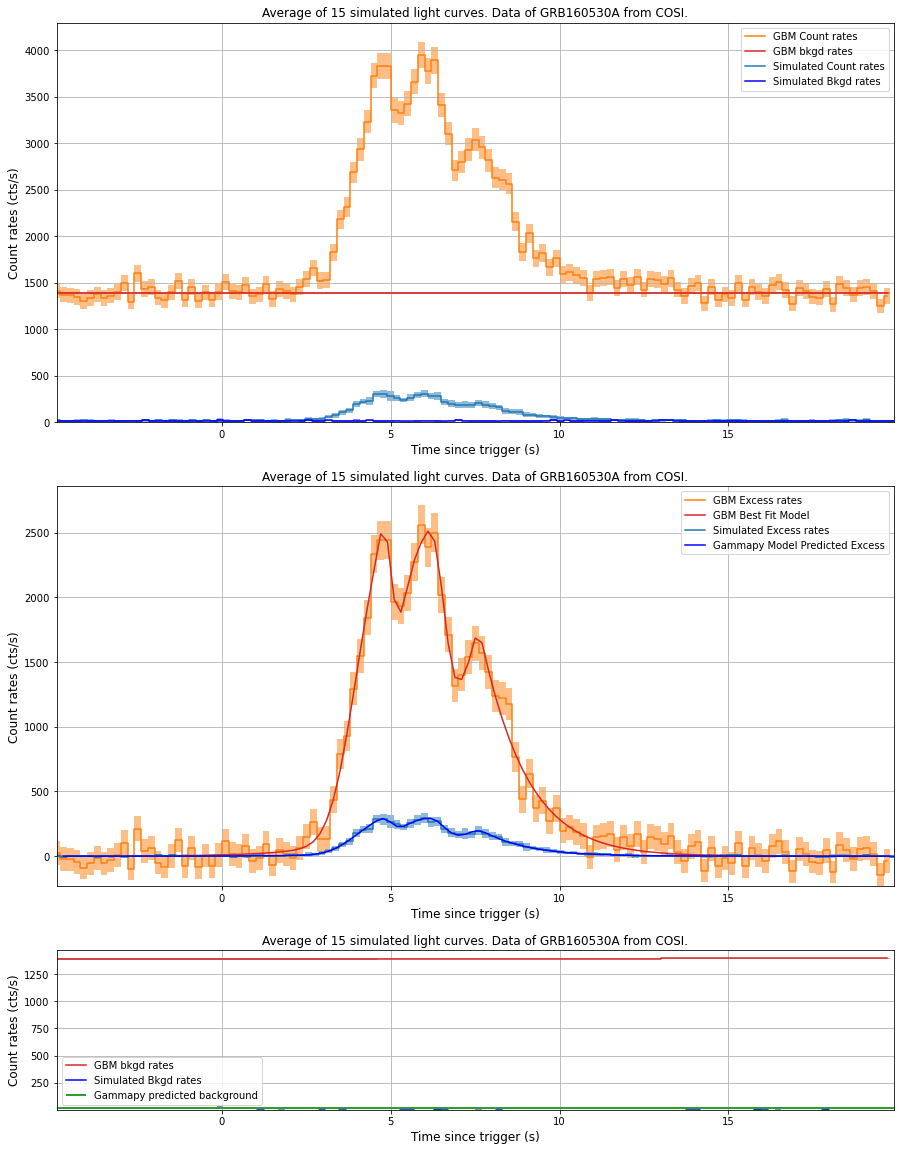

In [51]:
plot_light_curve(avg = True,
                 figsize = (15.0, 20.0),
                 #save_figures_directory = output_directory
                )

Choose one light curve

/tmp/ipykernel_5029/3263815767.py:30: RuntimeWarning: invalid value encountered in true_divide
  SIM_cnt_erro = SIM_cnt_rate / np.sqrt(datasets['counts'].value)
/tmp/ipykernel_5029/3263815767.py:34: RuntimeWarning: invalid value encountered in true_divide
  SIM_bkg_erro = SIM_bkg_rate / np.sqrt(datasets['background'].value)


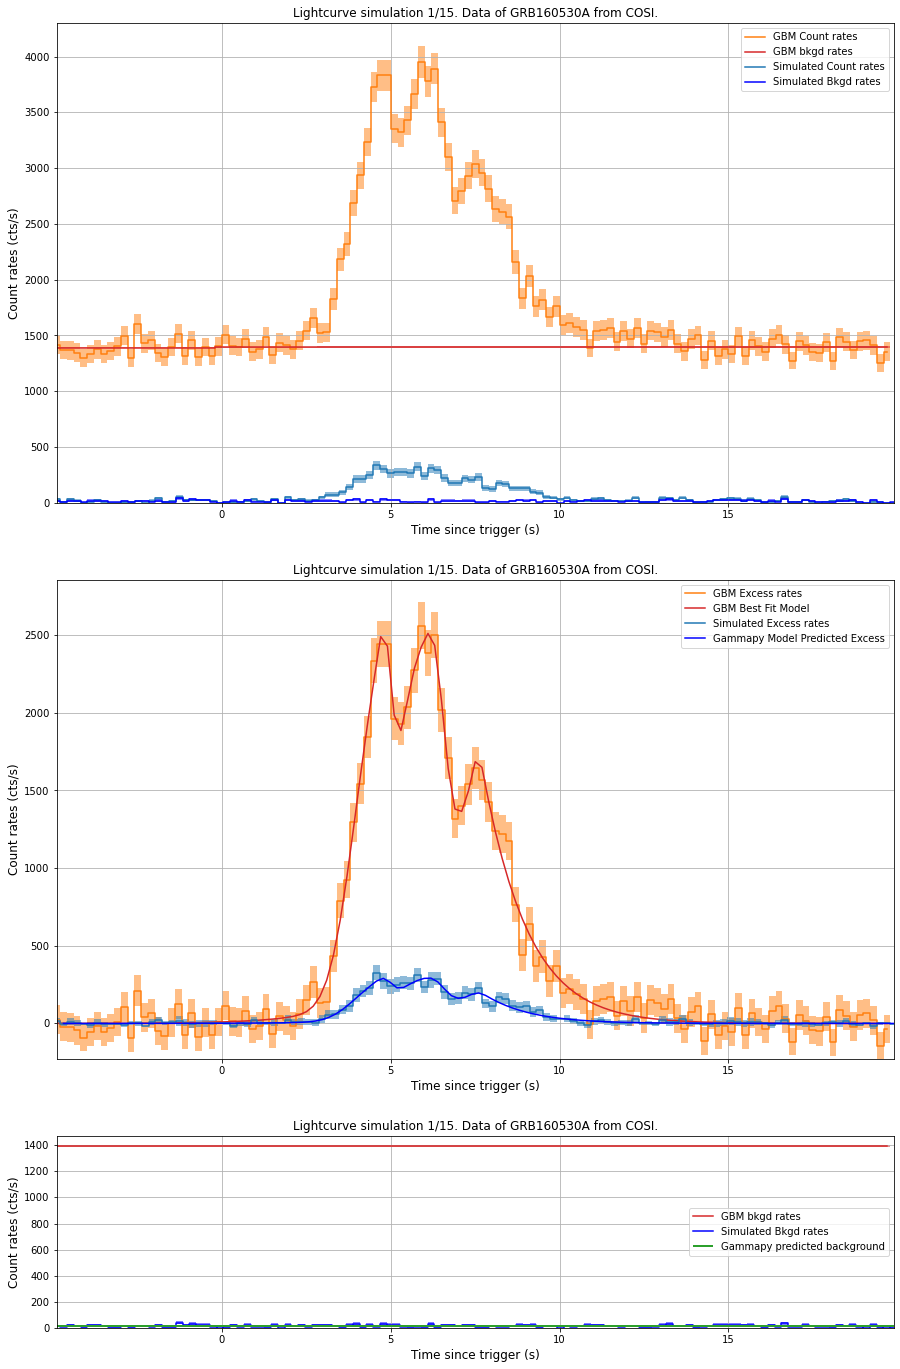

In [40]:
plot_light_curve(avg = False,
                 curve_index = 0,
                 figsize = (15.0, 24.0),
                 #save_figures_directory = output_directory
                )

# Export

In [41]:
hdu_list = []
hdu_list.append(fits.PrimaryHDU())

qtable = QTable(datasets_generic.info_table())
hdu_list.append(fits.table_to_hdu(qtable))

for i_LC in range(Number_of_LightCurves):
    qtable = QTable(List_of_Datasets[i_LC].info_table())
    hdu_list.append(fits.table_to_hdu(qtable))
    
hdu_list = fits.HDUList(hdu_list)

hdu_list.writeto(output_filename, overwrite=True)
print("Done.")

Done.


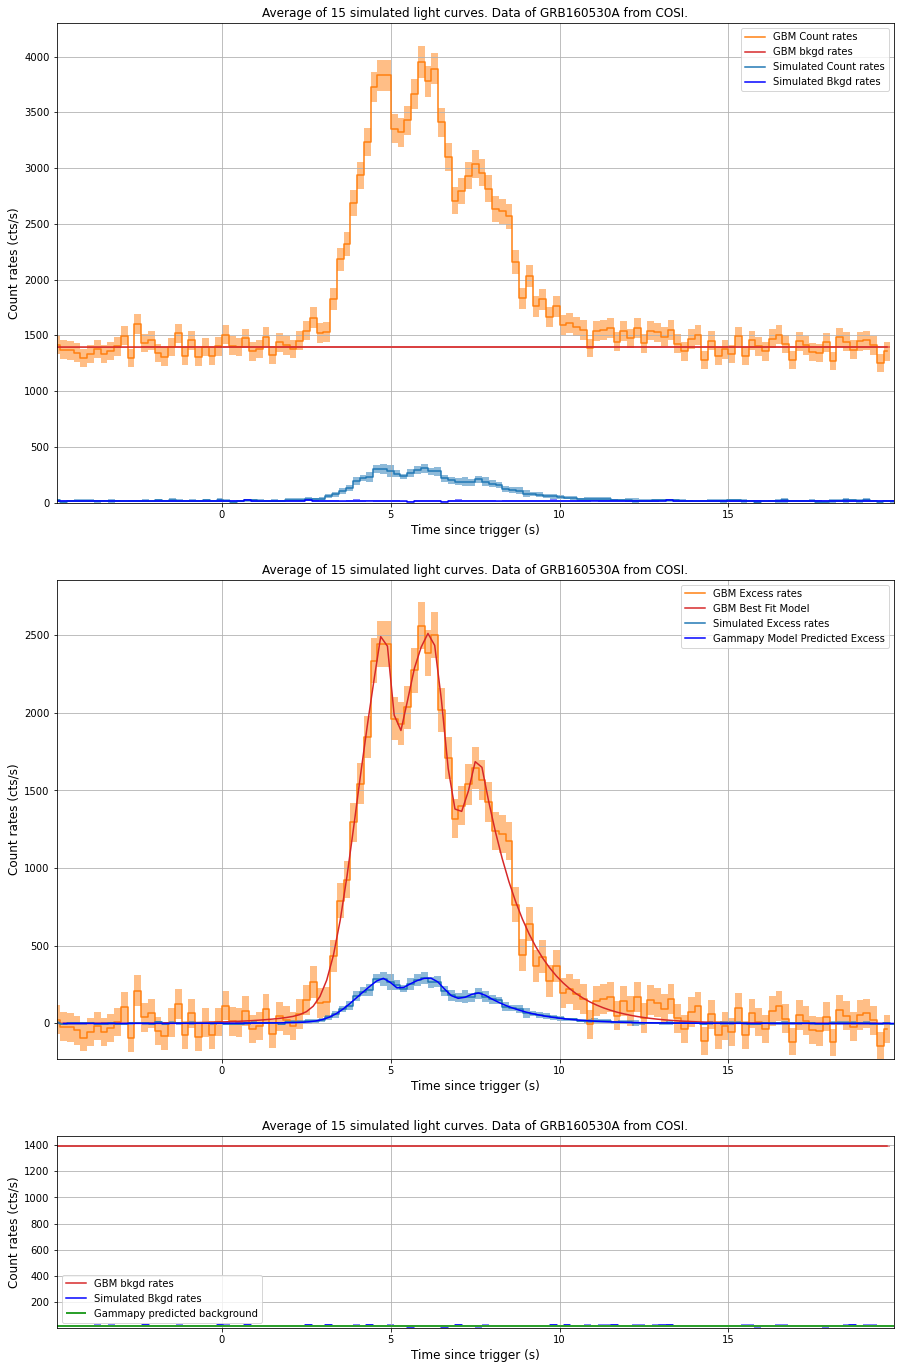

In [42]:
plot_light_curve(avg = True,
                 figsize = (15.0, 24.0),
                 save_figures_directory = output_directory
                )

/tmp/ipykernel_5029/3263815767.py:30: RuntimeWarning: invalid value encountered in true_divide
  SIM_cnt_erro = SIM_cnt_rate / np.sqrt(datasets['counts'].value)
/tmp/ipykernel_5029/3263815767.py:34: RuntimeWarning: invalid value encountered in true_divide
  SIM_bkg_erro = SIM_bkg_rate / np.sqrt(datasets['background'].value)


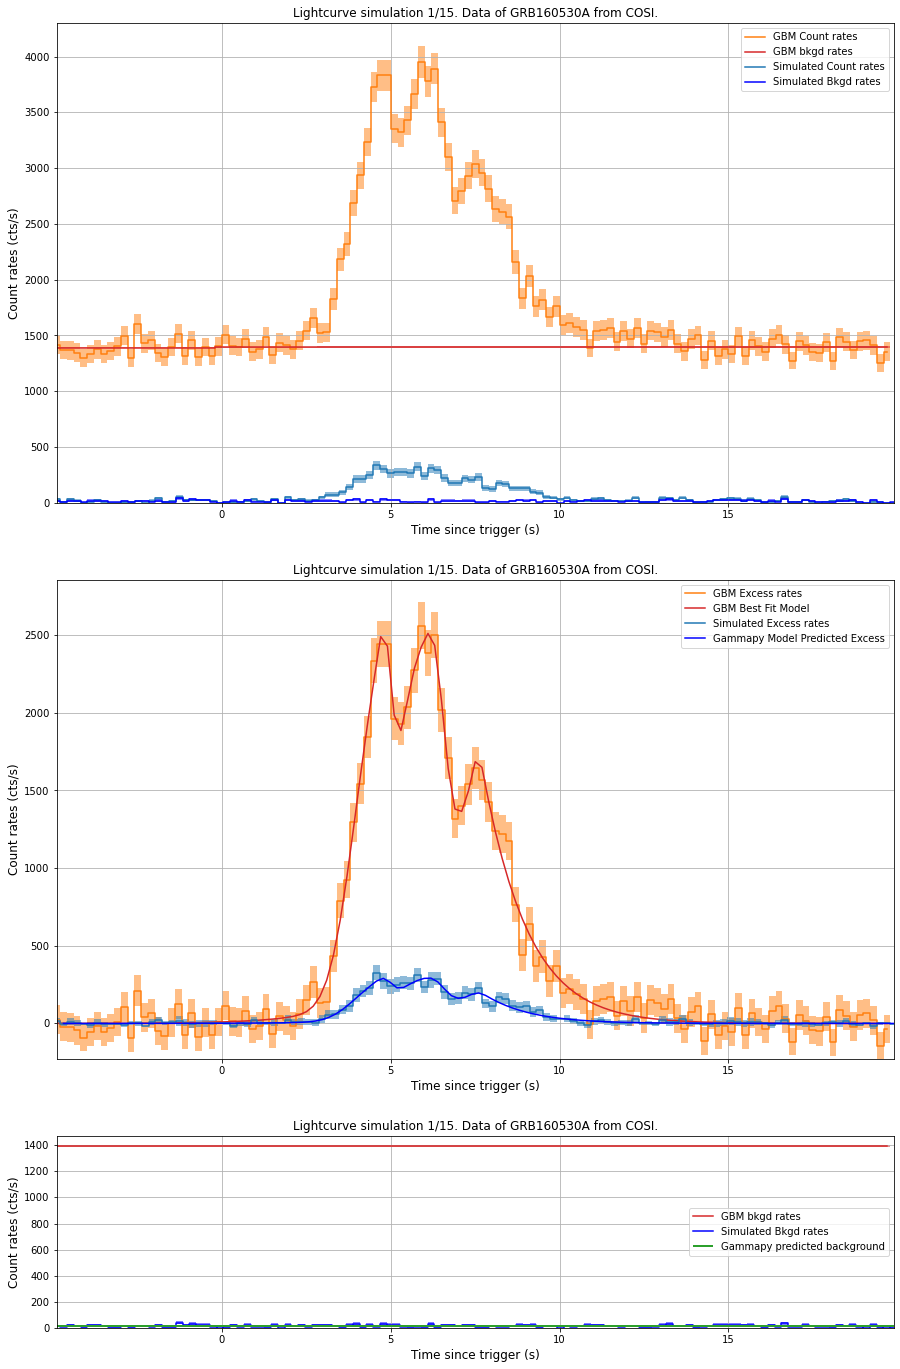

In [43]:
plot_light_curve(avg = False,
                 curve_index = 0,
                 figsize = (15.0, 24.0),
                 save_figures_directory = output_directory
                )

# Flux Points

In [ ]:
# datasets = List_of_Datasets[0]

In [ ]:
# # Drop the Temporal Model, attach only the Spectral Model to all SpectrumDataset objects
# datasets.models = SkyModel(spectral_model = spectral_model, name = "model-fit")
# datasets.models.to_parameters_table()

In [ ]:
# # Estimate a Flux Points light curve, each point is the flux of an observation
# # The estimator fits the norm of the source model component to datasets in each time interval GTI.
# #%%time
# lc_maker_1d = LightCurveEstimator(energy_edges = [axis_energy_true.edges[0], axis_energy_true.edges[-1]],#OR RECO?
#                                   source = "model-fit",
#                                   selection_optional = ["ul"]
#                                  )
# # "all": all the optional steps are executed
# # "errn-errp": estimate asymmetric errors.
# # "ul": estimate upper limits.
# # "scan": estimate fit statistic profiles.

# lc_1d = lc_maker_1d.run(datasets)

In [ ]:
# ax = lc_1d.plot(sed_type = "flux",  # "dnde", “flux”, “eflux”, “e2dnde”
#                 energy_power = 1.0, # Power of energy to multiply flux axis with
#                 marker = "o",
#                 label = "Simulated_LC")

# pl_start = ref_t0 - 0.3 * u.s
# pl_end   = ref_t0 + 0.8 * u.s
# #ax.set_xlim(pl_start.plot_date, pl_end.plot_date)

# Stacked Spectrum

In [ ]:
# datasets = List_of_Datasets[0]

In [ ]:
# Stack the Datasets into one Spectrum Dataset
# Stacked_spectrum_dataset = datasets.stack_reduce(name = 'Stacked_sim_ds')

In [ ]:
# fig, ax = plt.subplots(1, figsize = (7,5))
# Stacked_spectrum_dataset.plot_counts(ax=ax)
# ax.set_xscale('log')
# ax.set_title('Spectrum time-integrated (stacked)')
# plt.grid()
# plt.show()

# Other stuff

In [ ]:
# from gammapy.modeling.models import TemplateNPredModel

# dataset_generic.evaluators['Compt-TwoPulse'].model
# dataset_generic.evaluators['Compt-TwoPulse'].parameter_norm_only_changed
# dataset_generic.evaluators['Compt-TwoPulse'].methods_sequence

# if dataset_generic.evaluators['Compt-TwoPulse'].model.spatial_model:
#     print('spatial model: true')
# else: print('spatial model: false')
    
# print('psf_containment: ',dataset_generic.evaluators['Compt-TwoPulse'].psf_containment)

# flux = dataset_generic.evaluators['Compt-TwoPulse'].compute_flux()

# flux_expo = dataset_generic.evaluators['Compt-TwoPulse'].apply_exposure(flux)
# flux_expo_edisp = dataset_generic.evaluators['Compt-TwoPulse'].apply_edisp(flux_expo)
# dataset_generic.evaluators['Compt-TwoPulse'].edisp


# #print(temporal_model)
# #dataset_generic.npred_signal(model_name='Compt-TwoPulse')